# Imports

In [1]:
# data manipulation
import pandas as pd
import polars as pl
import numpy as np


# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# hypothesis testing
from scipy import stats
from scipy.stats import rankdata
from scipy.stats import wilcoxon, shapiro, ttest_ind, levene, f_oneway, mannwhitneyu
from scipy.stats.mstats import winsorize

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.stattools import medcouple

def cria_colunas(df: pl.DataFrame, tipo_df: str) -> pl.DataFrame:
    df = df.clone()
    map_dict_target = {
        2: "minor",
        3: "minor",
        4: "crititcal",
        5: "major",
        6: "none",
        7: "critical",
        8: "none",
        9: "major",
        10: "minor",
        11: "critical",
        12: "none",
        13: "major"
    }

    def map_values_target(x):
        return map_dict_target.get(x, x)

    df = df.with_columns(
        pl.col(f"{tipo_df}_target").map_elements(map_values_target, return_dtype=pl.String).alias("code_smell_target")
    )

    # mapeando tipo de smell por code snippet
    map_dict_type = {
        2: "long_method",
        3: "data_class",
        4: "feature_envy",
        5: "feature_envy",
        6: "none",
        7: "data_class",
        8: "none",
        9: "long_method",
        10: "feature_envy",
        11: "long_method",
        12: "none",
        13: "data_class"
    }

    def map_values_type(x):
        return map_dict_type.get(x, x)

    df = df.with_columns(
        pl.col(f"{tipo_df}_target").map_elements(map_values_type, return_dtype=pl.String).alias("code_smell_type")
    )

    return df

# Lendo os dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
fixation = pd.read_csv(r'/content/drive/MyDrive/fixation_geral/all_exp_fixations_original2.csv',
                       sep='\t',
                       usecols=['fixation_target', 'source_file_line', 'event', 'experiment', 'duration', 'date_hour', 'system_time'])
fixation = cria_colunas(pl.DataFrame(fixation), 'fixation').to_pandas()
print(fixation.shape)
fixation.head()

(76940, 9)


,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,long_method
1,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,long_method
2,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,long_method
3,2,77,1697813304400,97,2023-10-20T11:48:24.400000000,top-down-inside,1,minor,long_method
4,2,81,1697813304546,370,2023-10-20T11:48:24.546000000,top-down-inside,1,minor,long_method


In [4]:
answers_data_class = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Data Class')
answers_data_class['What code smell(s)?'] = 'Data Class'
answers_long_method = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Long Method')
answers_long_method['What code smell(s)?'] = 'Long Method'
answers_feature_envy = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Feature Envy')
answers_feature_envy['What code smell(s)?'] = 'Feature Envy'
answers_none = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'None')
answers_none['What code smell(s)?'] = 'None'
answers_others = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Others')
answers_none['What code smell(s)?'] = 'None'
answers_others['What code smell(s)?'] = 'Other'


answers = {'data_class': answers_data_class,
           'long_method': answers_long_method,
           'feature_envy': answers_feature_envy,
           'none': answers_none,
           'others': answers_others}

In [5]:
fixation.isna().sum()

,0
fixation_target,0
source_file_line,0
system_time,0
duration,0
date_hour,0
event,0
experiment,0
code_smell_target,0
code_smell_type,0


## Definido as seções

In [6]:
def define_secoes(row, num_lines):
    todo_codigo = list(range(1, num_lines+1))
    secoes = [todo_codigo[i:i+3] for i in range(0, len(todo_codigo ), 3)]
    for indice, secao in enumerate(secoes):
        if secao[0] <= row <= secao[-1]:  # Verifica se o número está dentro do intervalo da seção
            return indice + 1  # Retorna a seção (começando de 1)
    return None

In [7]:
num_lines = {
    2: 98,
    3: 41,
    4: 205,
    5: 398,
    6: 169,
    7: 56,
    8: 53,
    9: 2957,
    10: 852,
    11: 684,
    12: 667,
    13: 1148
}

for code in fixation['fixation_target'].unique():
    fixation.loc[fixation['fixation_target'] == code, 'section'] = fixation.loc[fixation['fixation_target'] == code, 'source_file_line'].apply(lambda x: define_secoes(x, num_lines[code]))

fixation['section'] = fixation['section'].astype(int)
fixation.head()

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,long_method,26
1,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,long_method,29
2,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,long_method,28
3,2,77,1697813304400,97,2023-10-20T11:48:24.400000000,top-down-inside,1,minor,long_method,26
4,2,81,1697813304546,370,2023-10-20T11:48:24.546000000,top-down-inside,1,minor,long_method,27


## Juntando fixation com as respostas

In [8]:
answers_df = pd.DataFrame()

for smell_type, df in answers.items():
    answers_df = pd.concat([answers_df, df])

In [9]:
answers_df[answers_df.duplicated(subset=['experiment_id', 'code_snippet'])]

,experiment_id,code_snippet,"Please, describe how the code snippets works.",Is the analyzed code snippets hard to comprehend?,"Based on the previous answer, explain why.",Is there a code smell in the analyzed code snippet?,What code smell(s)?,What is the code smell severity?,What was your reason for choosing this severity?,How did you feel during the analysis of this code snippet? (1 for very uncomfortable to 5 for very comfortable).
5,11,2,O nome do método não fala muito sobre seu obje...,No,É um código de complexidade muito grande para ...,Yes,Long Method,Critical,manutenção de curto e longo prazo,5
14,11,4,Código sujo e não seguindo um padrão de decodi...,Yes,"Não entendi muito bem o código, mas pelo nome ...",Yes,Long Method,Critical,difícil entendimento,3
18,11,5,"Comentário desnecessário, se o meu código não ...",Yes,Tá fazendo algumas coisas de difícil entendime...,Yes,Long Method,Critical,complexidade grande para investigações em prod...,3
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Long Method,Critical,"A função cria diversas variáveis, o que poderi...",2
44,11,11,Método faz muita coisa. \npassa um path de for...,Yes,"não entendi nada, por isso é difícil, tem muit...",Yes,Long Method,Critical,"não coloque em prod, esse método é complexo de...",5
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Feature Envy,Major,O método poderia ser dividido em dois: O prime...,5
2,11,2,O nome do método não fala muito sobre seu obje...,No,É um código de complexidade muito grande para ...,Yes,Feature Envy,Critical,manutenção de curto e longo prazo,5
4,16,2,O método recebe uma string e cria um arquivo c...,Yes,"O código não é de fácil compreensão, por algun...",Yes,Feature Envy,Minor,"Pois apesar de ser problemático, não é algo qu...",4
5,19,2,Escreve um arquivo que tem como nome o diretór...,Yes,"É um método um pouco longo, que faz duas funçõ...",Yes,Feature Envy,Major,Os code smells vão dificultar bastante o enten...,2
7,11,3,"Número mágico, poderia ter método get e set, o...",Yes,"Ferindo fatores importantes da POO, encapsulam...",Yes,Feature Envy,Major,aceitável dependendo do contexto do código,5


In [10]:
answers_df[answers_df['experiment_id'] == 1]

,experiment_id,code_snippet,"Please, describe how the code snippets works.",Is the analyzed code snippets hard to comprehend?,"Based on the previous answer, explain why.",Is there a code smell in the analyzed code snippet?,What code smell(s)?,What is the code smell severity?,What was your reason for choosing this severity?,How did you feel during the analysis of this code snippet? (1 for very uncomfortable to 5 for very comfortable).
28,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Data Class,Critical,"A função cria diversas variáveis, o que poderi...",2
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Long Method,Major,O método poderia ser dividido em dois: O prime...,5
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Long Method,Critical,"A função cria diversas variáveis, o que poderi...",2
39,1,11,A função retorna uma lista ordenada com os Ids...,No,Apesar de possuir diversos condicionais a lógi...,Yes,Long Method,Major,É um método longo que poderia ser simplificado...,4
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Feature Envy,Major,O método poderia ser dividido em dois: O prime...,5
10,1,5,A função verifica o tipo de instância dos obje...,No,"Apesar da recursão, o código é de simples ente...",Yes,Feature Envy,Critical,A recursividade pode causar um alto custo comp...,3
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Feature Envy,Critical,"A função cria diversas variáveis, o que poderi...",2
8,1,3,O código apresenta uma classe com seus atribut...,No,É um classe simples com poucas linhas de códig...,No,None,NaN,NaN,5
19,1,4,A função cria uma instância de um objeto com v...,No,É um código de simples entendimento pois cria ...,No,None,NaN,NaN,4
40,1,6,A função troca um delimitador dentro de uma st...,No,É uma função simples de formatação de strings.,No,None,NaN,NaN,4


In [11]:
# answers_df = answers_df.drop_duplicates(subset=['experiment_id', 'code_snippet'])

In [12]:
fix = fixation.merge(answers_df[['What code smell(s)?', 'code_snippet', 'experiment_id']], left_on=['experiment', 'fixation_target'], right_on=['experiment_id', 'code_snippet'], how='left')

In [13]:
display(fix.isna().sum().to_frame())

fix[fix.isna().any(axis=1)]

,0
fixation_target,0
source_file_line,0
system_time,0
duration,0
date_hour,0
event,0
experiment,0
code_smell_target,0
code_smell_type,0
section,0


,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id
564,12,563,1697815187526,150,2023-10-20T12:19:47.526000000,top-down-inside,1,none,none,188,NaN,NaN,NaN
565,12,561,1697815187716,140,2023-10-20T12:19:47.716000000,top-down-inside,1,none,none,187,NaN,NaN,NaN
566,12,563,1697815192595,357,2023-10-20T12:19:52.595000000,top-down-inside,1,none,none,188,NaN,NaN,NaN
567,12,563,1697815193002,153,2023-10-20T12:19:53.002000000,bottom-up-inside,1,none,none,188,NaN,NaN,NaN
568,12,563,1697815193196,165,2023-10-20T12:19:53.196000000,bottom-up-inside,1,none,none,188,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14890,12,563,1703006411036,1410,2023-12-19T14:20:11.036000000,bottom-up-inside,7,none,none,188,NaN,NaN,NaN
14891,13,966,1703006591545,136,2023-12-19T14:23:11.545000000,top-down-outside,7,major,data_class,322,NaN,NaN,NaN
14892,13,963,1703006592947,127,2023-12-19T14:23:12.947000000,bottom-up-outside,7,major,data_class,321,NaN,NaN,NaN
14893,13,953,1703006751306,109,2023-12-19T14:25:51.306000000,top-down-outside,7,major,data_class,318,NaN,NaN,NaN


In [14]:
fix['experiment'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 23, 24, 25, 26, 27])

In [15]:
fix[fix.isna().any(axis=1)]['experiment'].unique()

array([1, 2, 7])

In [16]:
fix = fix.dropna()

In [17]:
fix = fix.copy()
fix['code_smell_type'] = fix.loc[:, 'code_smell_type'].str.replace('_', ' ').str.title()

In [18]:
fix['mental_model'] = fix['event'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])

In [19]:
fix.head()

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id,mental_model
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down
1,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Feature Envy,2.0,1.0,top-down
2,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Long Method,2.0,1.0,top-down
3,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Feature Envy,2.0,1.0,top-down
4,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,Long Method,28,Long Method,2.0,1.0,bottom-up


## Retirando outliers

In [20]:
# result_df = pd.DataFrame(columns=['experiment_id', 'code_snippet', 'duration', 'What code smell(s)?', 'mental_model', 'code_smell_type', 'source_file_line', 'section', 'event'])

# known_terms = ['Long Method', 'Data Class', 'Feature Envy', 'None']

# long_method_res = []
# data_class_res = []
# feature_envy_res = []
# none_res = []
# others_res = []

# for index, row in fix.iterrows():
#     experiment, code_snippet = row['experiment_id'], row['code_snippet']
#     res = answers_df.loc[(answers_df['experiment_id'] == experiment) & (answers_df['code_snippet'] == code_snippet), 'What code smell(s)?']
#     # print(res.values[0])
#     # break

#     # print(res.values)

#     # separando para caso tiver mais de um code smell
#     smells_type_res = res.values[0].split(', ')
#     # print([s for s in smells_type_res])

#     for s in smells_type_res:
#         if s == '':
#             continue
#         if 'Long Method' in s:
#             if 73.963 <= row['duration'] <= 2428.371:
#                 long_method_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Long Method', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'Data Class' in s:
#             if 79.464 <= row['duration'] <= 3072.444:
#                 data_class_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Data Class', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'Feature Envy' in s:
#             if 77.030 <= row['duration'] <= 2487.983:
#                 feature_envy_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Feature Envy', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'None' in s:
#             if 60.484 <= row['duration'] <= 2430.436:
#                 none_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'], 'None',
#                                                  row['mental_model'], row['code_smell_type'],
#                                                  row['source_file_line'], row['section'], row['event']]
#         if any(term not in known_terms for term in s.split(', ')) or 'Others' in s:
#             if 69.531 <= row['duration'] <= 2294.185:
#                 others_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  "Other", row['mental_model'], row['code_smell_type'],
#                                                  row['source_file_line'], row['section'], row['event']]
#             break

# result_df.to_csv('all_exp_fixation_treated_by_response.csv', index=False)

In [21]:
result_df = pd.read_csv(r'/content/drive/MyDrive/fixation_geral/all_exp_fixation_treated_by_response.csv', na_values=[''], keep_default_na=False)

result_df.head()

,experiment_id,code_snippet,duration,What code smell(s)?,mental_model,code_smell_type,source_file_line,section,event
0,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside
1,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside
2,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside
3,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside
4,1.0,2.0,157,Long Method,top-down,Long Method,86,29,top-down-inside


In [22]:
fix['classified_as_smell'] = fix['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [23]:
result_df.shape

(90829, 9)

In [24]:
result_df.isna().sum()

,0
experiment_id,0
code_snippet,0
duration,0
What code smell(s)?,0
mental_model,0
code_smell_type,0
source_file_line,0
section,0
event,0


In [25]:
result_df['classified_as_smell'] = result_df['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [26]:
result_df.classified_as_smell.value_counts()

,count
classified_as_smell,
True,59021
False,31808


## Tratando outliers - Winsorize

In [27]:
long_method_res = fix.loc[fix['What code smell(s)?'] == 'Long Method', 'duration'].values
data_class_res = fix.loc[fix['What code smell(s)?'] == 'Data Class', 'duration'].values
feature_envy_res = fix.loc[fix['What code smell(s)?'] == 'Feature Envy', 'duration'].values
none_res = fix.loc[fix['What code smell(s)?'] == 'None', 'duration'].values
others_res = fix.loc[fix['What code smell(s)?'] == 'Other', 'duration'].values

In [28]:
def adjusted_boxplot(data):
    # Primeiro, ordene os dados
    data = np.sort(data)

    # Calcule o primeiro e terceiro quartis (Q1 e Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Calcule a skewness Medcouple (MC)
    MC = medcouple(data)

    # Fator de ajuste para os limites superior e inferior
    if MC > 0:  # Skewness positiva
        lower_limit = Q1 - 1.5 * np.exp(-4 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(3 * MC) * IQR
    elif MC < 0:  # Skewness negativa
        lower_limit = Q1 - 1.5 * np.exp(-3 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(4 * MC) * IQR
    else:  # Distribuição simétrica
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

    # Identificar outliers com base nos limites ajustados
    outliers = data[(data < lower_limit) | (data > upper_limit)]
    non_outliers = data[(data >= lower_limit) & (data <= upper_limit)]

    return lower_limit, upper_limit, outliers, non_outliers

lower_limit_lm, upper_limit_lm, outliers_lm, non_outliers_lm = adjusted_boxplot(long_method_res)

lm = pd.DataFrame(index=['long_method' for i in range(len(long_method_res))], data=long_method_res).reset_index()
lm.columns = ['smells_type', 'duration']

lower_limit_dc, upper_limit_dc, outliers_dc, non_outliers_dc = adjusted_boxplot(data_class_res)

dc = pd.DataFrame(index=['data_class' for i in range(len(data_class_res))], data=data_class_res).reset_index()
dc.columns = ['smells_type', 'duration']

lower_limit_fe, upper_limit_fe, outliers_fe, non_outliers_fe = adjusted_boxplot(feature_envy_res)

fe = pd.DataFrame(index=['feature_envy' for i in range(len(feature_envy_res))], data=feature_envy_res).reset_index()
fe.columns = ['smells_type', 'duration']

lower_limit_no, upper_limit_no, outliers_no, non_outliers_no = adjusted_boxplot(none_res)

no = pd.DataFrame(index=['none' for i in range(len(none_res))], data=none_res).reset_index()
no.columns = ['smells_type', 'duration']

lower_limit_others, upper_limit_others, outliers_others, non_outliers_others = adjusted_boxplot(others_res)

others = pd.DataFrame(index=['others' for i in range(len(others_res))], data=others_res).reset_index()
others.columns = ['smells_type', 'duration']

In [29]:
print(f'long_method lower limit: {float(lower_limit_lm):.3f}, long_method upper limit: {float(upper_limit_lm):.3f}')

print(f'data_class lower limit: {float(lower_limit_dc):.3f}, data_class upper limit: {float(upper_limit_dc):.3f}')

print(f'feature_envy lower limit: {float(lower_limit_fe):.3f}, feature_envy upper limit: {float(upper_limit_fe):.3f}')

print(f'none lower limit: {float(lower_limit_no):.3f}, none upper limit: {float(upper_limit_no):.3f}')

print(f'others lower limit: {float(lower_limit_others):.3f}, others upper limit: {float(upper_limit_others):.3f}')

long_method lower limit: 73.963, long_method upper limit: 2428.371
data_class lower limit: 79.385, data_class upper limit: 3058.695
feature_envy lower limit: 77.030, feature_envy upper limit: 2487.983
none lower limit: 60.484, none upper limit: 2430.436
others lower limit: 68.443, others upper limit: 2280.050


In [30]:
fix['duration'] = fix['duration'].astype(float)
fix.loc[fix['What code smell(s)?'] == "Long Method", "duration"] = fix.loc[fix['What code smell(s)?'] == "Long Method", "duration"].clip(lower=73.963, upper=2428.371)
fix.loc[fix['What code smell(s)?'] == "Data Class", "duration"] = fix.loc[fix['What code smell(s)?'] == "Data Class", "duration"].clip(lower=79.385, upper=3058.695)
fix.loc[fix['What code smell(s)?'] == "Feature Envy", "duration"] = fix.loc[fix['What code smell(s)?'] == "Feature Envy", "duration"].clip(lower=77.030, upper=2487.983)
fix.loc[fix['What code smell(s)?'] == "None", "duration"] = fix.loc[fix['What code smell(s)?'] == "None", "duration"].clip(lower=60.484, upper=2430.436)
fix.loc[fix['What code smell(s)?'] == "Other", "duration"] = fix.loc[fix['What code smell(s)?'] == "Other", "duration"].clip(lower=68.443, upper=2280.050)

# fix_response.loc[fix_response['What code smell(s)?'] == "Long Method", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Long Method", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "Data Class", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Data Class", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "Feature Envy", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Feature Envy", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "None", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "None", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] != "None", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] != "None", "duration"], (0.025, 0.025))

In [31]:
fix['classified_as_smell'] = fix['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [32]:
fix_response = fix.copy()

# RQ3

## Reading Patterns

In [33]:
fix_patterns = pd.DataFrame()

for snippet in fix['code_snippet'].unique():
    for experiment in fix['experiment_id'].unique():
        fixation_ = fix.loc[(fix['code_snippet'] == snippet) & (fix['experiment_id'] == experiment)].copy()

        fixation_['pattern'] = fixation_['source_file_line'].diff().apply(lambda x: 'top-to-bottom' if x >=0 else 'bottom-to-top')

        fix_patterns = pd.concat([fix_patterns, fixation_])

In [34]:
fix_patterns.head()

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id,mental_model,classified_as_smell,pattern
0,2,77,1697813303583,107.0,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down,True,bottom-to-top
1,2,77,1697813303583,107.0,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Feature Envy,2.0,1.0,top-down,True,top-to-bottom
2,2,86,1697813303759,157.0,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Long Method,2.0,1.0,top-down,True,top-to-bottom
3,2,86,1697813303759,157.0,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Feature Envy,2.0,1.0,top-down,True,top-to-bottom
4,2,83,1697813303966,374.0,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,Long Method,28,Long Method,2.0,1.0,bottom-up,True,bottom-to-top


In [35]:
fix_patterns.pattern.value_counts()

,count
pattern,
top-to-bottom,57782
bottom-to-top,23139


In [36]:
duration_sum_pattern = fix_patterns.groupby(['code_snippet', 'experiment_id', 'pattern'])['duration'].sum()
duration_sum_pattern.head()

code_snippet  experiment_id  pattern      
2.0           1.0            bottom-to-top     15173.742
                             top-to-bottom     48388.966
              2.0            bottom-to-top     77062.983
                             top-to-bottom    151763.915
              3.0            bottom-to-top     77003.371
Name: duration, dtype: float64

In [37]:
duration_sum_pattern = fix_patterns.groupby(['code_snippet', 'experiment_id', 'pattern'])['duration'].sum()

duration_percentage_pattern = duration_sum_pattern / duration_sum_pattern.groupby(['code_snippet', 'experiment_id']).transform('sum') * 100

duration_percentage_pattern = duration_percentage_pattern.reset_index(name='duration_percentage')

duration_percentage_pattern.head()

,code_snippet,experiment_id,pattern,duration_percentage
0,2.0,1.0,bottom-to-top,23.872082
1,2.0,1.0,top-to-bottom,76.127918
2,2.0,2.0,bottom-to-top,33.677415
3,2.0,2.0,top-to-bottom,66.322585
4,2.0,3.0,bottom-to-top,33.704045


## Mental Model (Bottom-up vs Top-down) por tipo de smells na resposta

In [38]:
fix_response

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id,mental_model,classified_as_smell
0,2,77,1697813303583,107.0,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down,True
1,2,77,1697813303583,107.0,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Feature Envy,2.0,1.0,top-down,True
2,2,86,1697813303759,157.0,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Long Method,2.0,1.0,top-down,True
3,2,86,1697813303759,157.0,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Feature Envy,2.0,1.0,top-down,True
4,2,83,1697813303966,374.0,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,Long Method,28,Long Method,2.0,1.0,bottom-up,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82349,13,959,1714690942759,274.0,2024-05-02T20:02:22.759000000,bottom-up-outside,27,major,Data Class,320,None,13.0,27.0,bottom-up,False
82350,13,962,1714690944226,460.0,2024-05-02T20:02:24.226000000,bottom-up-outside,27,major,Data Class,321,None,13.0,27.0,bottom-up,False
82351,13,959,1714690945664,675.0,2024-05-02T20:02:25.664000000,bottom-up-outside,27,major,Data Class,320,None,13.0,27.0,bottom-up,False
82352,13,962,1714690946482,367.0,2024-05-02T20:02:26.482000000,bottom-up-outside,27,major,Data Class,321,None,13.0,27.0,bottom-up,False


In [39]:
len(fix_response)

80921

In [40]:
duration_sum = fix_response.groupby(['What code smell(s)?', 'code_snippet', 'experiment_id', 'mental_model'])['duration'].sum()

In [41]:
duration_percentage = duration_sum / duration_sum.groupby(['What code smell(s)?', 'code_snippet', 'experiment_id']).transform('sum') * 100

duration_percentage = duration_percentage.reset_index(name='duration_percentage')

duration_percentage

,What code smell(s)?,code_snippet,experiment_id,mental_model,duration_percentage
0,Data Class,2.0,11.0,bottom-up,71.900248
1,Data Class,2.0,11.0,top-down,28.099752
2,Data Class,3.0,3.0,bottom-up,75.742565
3,Data Class,3.0,3.0,top-down,24.257435
4,Data Class,3.0,4.0,bottom-up,54.940006
...,...,...,...,...,...
623,Other,13.0,6.0,top-down,10.348833
624,Other,13.0,18.0,bottom-up,57.434531
625,Other,13.0,18.0,top-down,42.565469
626,Other,13.0,26.0,bottom-up,93.561421


In [42]:
duration_percentage_data_class = duration_percentage[duration_percentage['What code smell(s)?'] == 'Data Class']
duration_percentage_long_method = duration_percentage[duration_percentage['What code smell(s)?'] == 'Long Method']
duration_percentage_feature_envy = duration_percentage[duration_percentage['What code smell(s)?'] == 'Feature Envy']
duration_percentage_none = duration_percentage[duration_percentage['What code smell(s)?'] == 'None']
duration_percentage_other = duration_percentage[duration_percentage['What code smell(s)?'] == 'Other']

### Mental Model Long Method

In [43]:
long_method_bottom_up = duration_percentage_long_method[duration_percentage_long_method['mental_model'] == 'bottom-up']
long_method_top_down = duration_percentage_long_method[duration_percentage_long_method['mental_model'] == 'top-down']

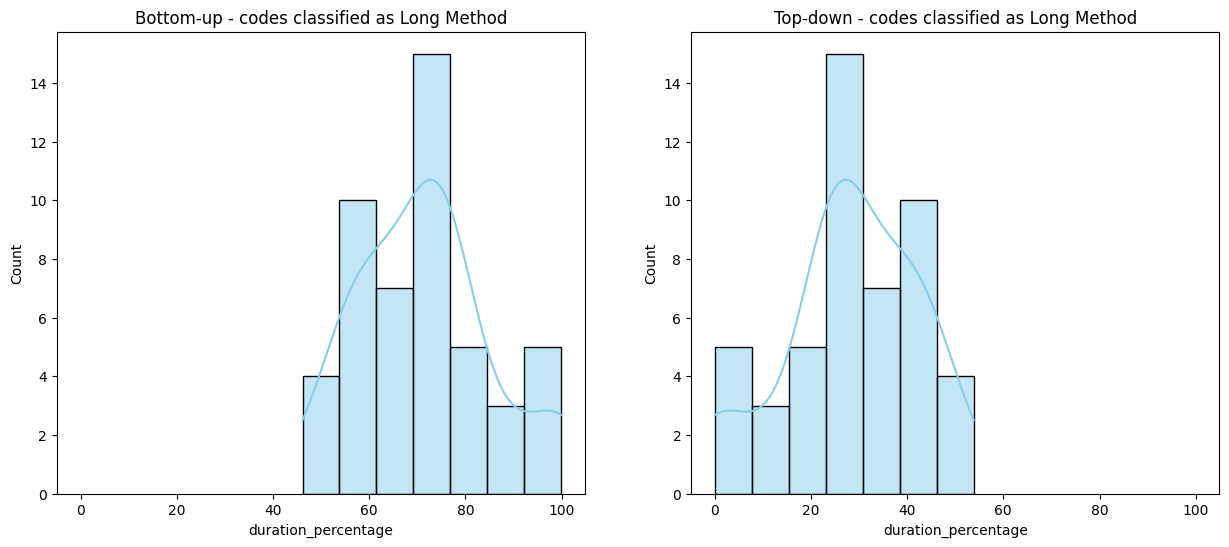

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.histplot(long_method_bottom_up['duration_percentage'], ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Bottom-up - codes classified as Long Method')

sns.histplot(long_method_top_down['duration_percentage'], ax=ax[1], kde=True, color='skyblue')
ax[1].set_title('Top-down - codes classified as Long Method')

plt.show()

#### Teste para verificar a normalidade (Shapiro-Wilk)

---



    H0: A distribuição é aproximadamente normal.
    H1: A distribuição não é aproximadamente normal

In [45]:
statistic_bottom_up, p_value_bottom_up = shapiro(long_method_bottom_up['duration_percentage'])
statistic_top_down, p_value_top_down = shapiro(long_method_top_down['duration_percentage'])

alpha = 0.05

if p_value_bottom_up > alpha:
    print("A distribuição de 'long_method_bottom_up' é aproximadamente normal.")
else:
    print("A distribuição de 'long_method_bottom_up' não é aproximadamente normal.")

if p_value_top_down > alpha:
    print("A distribuição de 'long_method_top_down' é aproximadamente normal.")
else:
    print("A distribuição de 'long_method_top_down' não é aproximadamente normal.")

A distribuição de 'long_method_bottom_up' não é aproximadamente normal.
A distribuição de 'long_method_top_down' não é aproximadamente normal.


#### Diferença para códigos que foram classificados como Long Method (bottom-up vs top-down):

---



    H0: Em códigos classificados como Long Method, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

    H1: Em códigos classificados como Long Method, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

In [46]:
statistic, p_value = wilcoxon(long_method_bottom_up['duration_percentage'], long_method_top_down['duration_percentage'])

print(f"Wilcoxon statistic: {statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")
else:
    print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")

Wilcoxon statistic: 5.0
p-value: 3.552713678800501e-14
H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.


In [47]:
n_long_method_bottom_up = len(long_method_bottom_up)
n_long_method_top_down = len(long_method_top_down)

print(f"n_long_method_bottom_up: {n_long_method_bottom_up}")
print(f"n_long_method_top_down: {n_long_method_top_down}")

mu_u = (n_long_method_bottom_up * n_long_method_top_down) / 2

sigma_u = np.sqrt((n_long_method_bottom_up * n_long_method_top_down * (n_long_method_bottom_up + n_long_method_top_down + 1)) / 12)

combined_data = np.concatenate([long_method_bottom_up['duration_percentage'], long_method_top_down['duration_percentage']])

ranks = rankdata(combined_data)

ranks_long_method_bottom_up = ranks[:len(long_method_bottom_up['duration_percentage'])]
ranks_long_method_top_down = ranks[len(long_method_top_down['duration_percentage']):]

sum_ranks_long_method_bottom_up = np.sum(ranks_long_method_bottom_up)
sum_ranks_long_method_top_down = np.sum(ranks_long_method_top_down)

print(f"Soma dos ranks de 'long_method_bottom_up': {sum_ranks_long_method_bottom_up}")
print(f"Soma dos ranks de 'long_method_top_down': {sum_ranks_long_method_top_down}")

z = (statistic - mu_u) / sigma_u

print("Estatística Z:", z)

n_long_method_bottom_up: 49
n_long_method_top_down: 49
Soma dos ranks de 'long_method_bottom_up': 3618.0
Soma dos ranks de 'long_method_top_down': 1233.0
Estatística Z: -8.494279089593338


### Mental Model Data Class

In [48]:
data_class_bottom_up = duration_percentage_data_class[duration_percentage_data_class['mental_model'] == 'bottom-up']
data_class_top_down = duration_percentage_data_class[duration_percentage_data_class['mental_model'] == 'top-down']

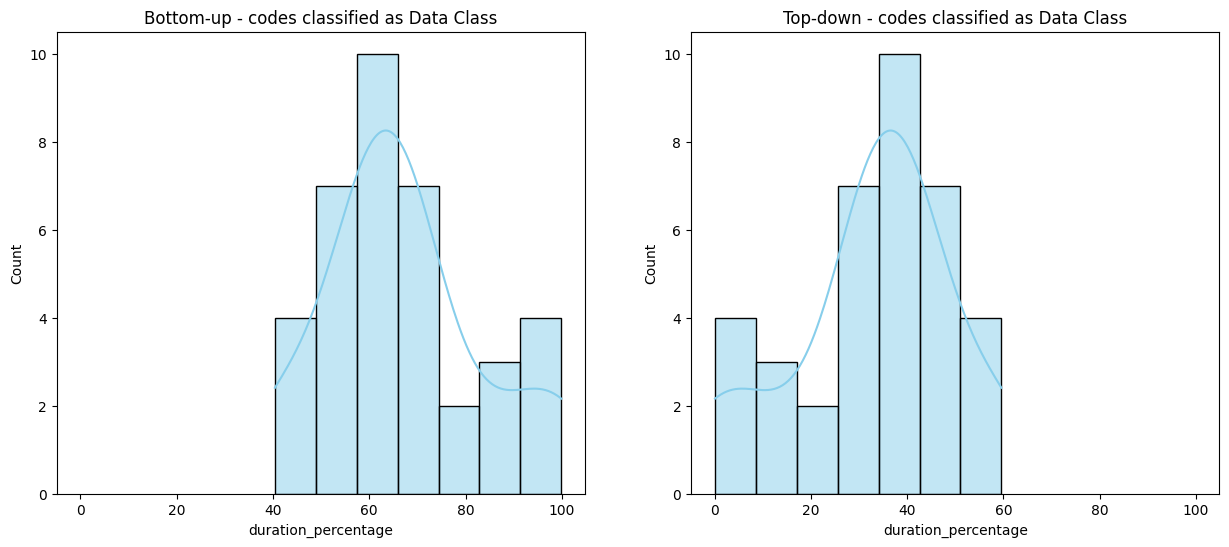

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.histplot(data_class_bottom_up['duration_percentage'], ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Bottom-up - codes classified as Data Class')

sns.histplot(data_class_top_down['duration_percentage'], ax=ax[1], kde=True, color='skyblue')
ax[1].set_title('Top-down - codes classified as Data Class')

plt.show()

#### Teste para verificar a normalidade (Shapiro-Wilk)

---



    H0: A distribuição é aproximadamente normal.
    H1: A distribuição não é aproximadamente normal

In [50]:
statistic_bottom_up, p_value_bottom_up = shapiro(data_class_bottom_up['duration_percentage'])
statistic_top_down, p_value_top_down = shapiro(data_class_top_down['duration_percentage'])

alpha = 0.05

if p_value_bottom_up > alpha:
    print("A distribuição de 'data_class_bottom_up' é aproximadamente normal.")
else:
    print("A distribuição de 'data_class_bottom_up' não é aproximadamente normal.")

if p_value_top_down > alpha:
    print("A distribuição de 'data_class_top_down' é aproximadamente normal.")
else:
    print("A distribuição de 'data_class_top_down' não é aproximadamente normal.")

A distribuição de 'data_class_bottom_up' não é aproximadamente normal.
A distribuição de 'data_class_top_down' não é aproximadamente normal.


#### Diferença para códigos que foram classificados como Data Class (bottom-up vs top-down):

---



    H0: Em códigos classificados como Data Class, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

    H1: Em códigos classificados como Data Class, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

In [51]:
statistic, p_value = wilcoxon(data_class_bottom_up['duration_percentage'], data_class_top_down['duration_percentage'])

print(f"Wilcoxon statistic: {statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")
else:
    print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")

Wilcoxon statistic: 38.0
p-value: 9.605719242244959e-08
H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.


In [52]:
n_data_class_bottom_up = len(data_class_bottom_up)
n_data_class_top_down = len(data_class_top_down)

print(f"n_data_class_bottom_up: {n_data_class_bottom_up}")
print(f"n_data_class_top_down: {n_data_class_top_down}")

mu_u = (n_data_class_bottom_up * n_data_class_top_down) / 2

sigma_u = np.sqrt((n_data_class_bottom_up * n_data_class_top_down * (n_data_class_bottom_up + n_data_class_top_down + 1)) / 12)

combined_data = np.concatenate([data_class_bottom_up['duration_percentage'], data_class_top_down['duration_percentage']])

ranks = rankdata(combined_data)

ranks_data_class_bottom_up = ranks[:len(data_class_bottom_up['duration_percentage'])]
ranks_data_class_top_down = ranks[len(data_class_top_down['duration_percentage']):]

sum_ranks_data_class_bottom_up = np.sum(ranks_data_class_bottom_up)
sum_ranks_data_class_top_down = np.sum(ranks_data_class_top_down)

print(f"Soma dos ranks de 'data_class_bottom_up': {sum_ranks_data_class_bottom_up}")
print(f"Soma dos ranks de 'data_class_top_down': {sum_ranks_data_class_top_down}")

z = (statistic - mu_u) / sigma_u

print("Estatística Z:", z)

n_data_class_bottom_up: 37
n_data_class_top_down: 37
Soma dos ranks de 'data_class_bottom_up': 2000.0
Soma dos ranks de 'data_class_top_down': 775.0
Estatística Z: -6.989189189189189


### Mental Model Feature Envy

In [53]:
feature_envy_bottom_up = duration_percentage_feature_envy[duration_percentage_feature_envy['mental_model'] == 'bottom-up']
feature_envy_top_down = duration_percentage_feature_envy[duration_percentage_feature_envy['mental_model'] == 'top-down']

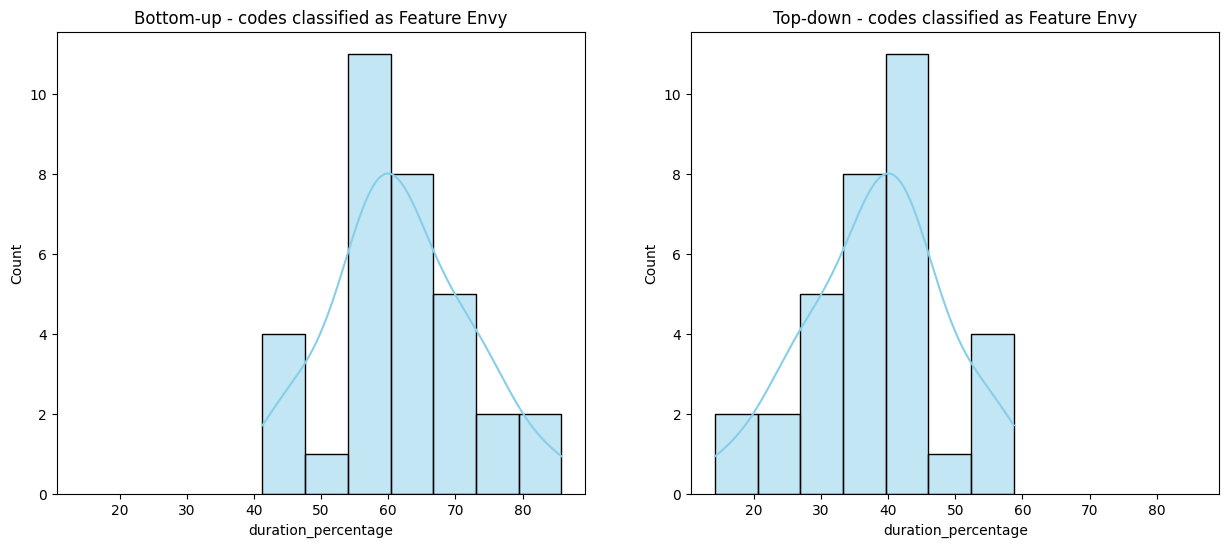

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.histplot(feature_envy_bottom_up['duration_percentage'], ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Bottom-up - codes classified as Feature Envy')

sns.histplot(feature_envy_top_down['duration_percentage'], ax=ax[1], kde=True, color='skyblue')
ax[1].set_title('Top-down - codes classified as Feature Envy')

plt.show()

#### Teste para verificar a normalidade (Shapiro-Wilk)

---



    H0: A distribuição é aproximadamente normal.
    H1: A distribuição não é aproximadamente normal

In [55]:
statistic_bottom_up, p_value_bottom_up = shapiro(feature_envy_bottom_up['duration_percentage'])
statistic_top_down, p_value_top_down = shapiro(feature_envy_top_down['duration_percentage'])

alpha = 0.05

if p_value_bottom_up > alpha:
    print("A distribuição de 'feature_envy_bottom_up' é aproximadamente normal.")
else:
    print("A distribuição de 'feature_envy_bottom_up' não é aproximadamente normal.")

if p_value_top_down > alpha:
    print("A distribuição de 'feature_envy_top_down' é aproximadamente normal.")
else:
    print("A distribuição de 'feature_envy_top_down' não é aproximadamente normal.")

A distribuição de 'feature_envy_bottom_up' é aproximadamente normal.
A distribuição de 'feature_envy_top_down' é aproximadamente normal.


#### Diferença para códigos que foram classificados como Feature Envy (bottom-up vs top-down):

---



    H0: Em códigos classificados como Feature Envy, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

    H1: Em códigos classificados como Feature Envy, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

In [56]:
statistic, p_value = wilcoxon(feature_envy_bottom_up['duration_percentage'], feature_envy_top_down['duration_percentage'])

print(f"Wilcoxon statistic: {statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")
else:
    print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")

Wilcoxon statistic: 26.0
p-value: 2.4889595806598663e-07
H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.


In [57]:
n_feature_envy_bottom_up = len(feature_envy_bottom_up)
n_feature_envy_top_down = len(feature_envy_top_down)

print(f"n_feature_envy_bottom_up: {n_feature_envy_bottom_up}")
print(f"n_feature_envy_top_down: {n_feature_envy_top_down}")

mu_u = (n_feature_envy_bottom_up * n_feature_envy_top_down) / 2

sigma_u = np.sqrt((n_feature_envy_bottom_up * n_feature_envy_top_down * (n_feature_envy_bottom_up + n_feature_envy_top_down + 1)) / 12)

combined_data = np.concatenate([feature_envy_bottom_up['duration_percentage'], feature_envy_top_down['duration_percentage']])

ranks = rankdata(combined_data)

ranks_feature_envy_bottom_up = ranks[:len(feature_envy_bottom_up['duration_percentage'])]
ranks_feature_envy_top_down = ranks[len(feature_envy_top_down['duration_percentage']):]

sum_ranks_feature_envy_bottom_up = np.sum(ranks_feature_envy_bottom_up)
sum_ranks_feature_envy_top_down = np.sum(ranks_feature_envy_top_down)

print(f"Soma dos ranks de 'feature_envy_bottom_up': {sum_ranks_feature_envy_bottom_up}")
print(f"Soma dos ranks de 'feature_envy_top_down': {sum_ranks_feature_envy_top_down}")

z = (statistic - mu_u) / sigma_u

print("Estatística Z:", z)

n_feature_envy_bottom_up: 33
n_feature_envy_top_down: 33
Soma dos ranks de 'feature_envy_bottom_up': 1603.0
Soma dos ranks de 'feature_envy_top_down': 608.0
Estatística Z: -6.6494854876851495


### Mental Model None

In [58]:
none_bottom_up = duration_percentage_none[duration_percentage_none['mental_model'] == 'bottom-up']
none_top_down = duration_percentage_none[duration_percentage_none['mental_model'] == 'top-down']

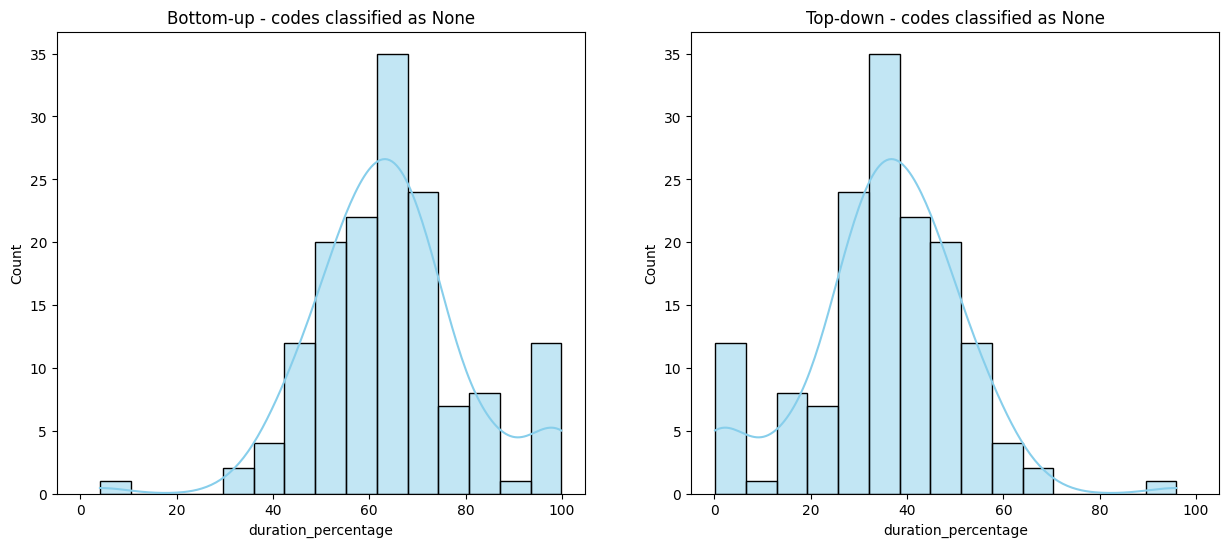

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.histplot(none_bottom_up['duration_percentage'], ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Bottom-up - codes classified as None')

sns.histplot(none_top_down['duration_percentage'], ax=ax[1], kde=True, color='skyblue')
ax[1].set_title('Top-down - codes classified as None')

plt.show()

#### Teste para verificar a normalidade (Shapiro-Wilk)

---



    H0: A distribuição é aproximadamente normal.
    H1: A distribuição não é aproximadamente normal

In [60]:
statistic_bottom_up, p_value_bottom_up = shapiro(none_bottom_up['duration_percentage'])
statistic_top_down, p_value_top_down = shapiro(none_top_down['duration_percentage'])

alpha = 0.05

if p_value_bottom_up > alpha:
    print("A distribuição de 'none_bottom_up' é aproximadamente normal.")
else:
    print("A distribuição de 'none_bottom_up' não é aproximadamente normal.")

if p_value_top_down > alpha:
    print("A distribuição de 'none_top_down' é aproximadamente normal.")
else:
    print("A distribuição de 'none_top_down' não é aproximadamente normal.")

A distribuição de 'none_bottom_up' não é aproximadamente normal.
A distribuição de 'none_top_down' não é aproximadamente normal.


#### Diferença para códigos que foram classificados como None (bottom-up vs top-down):

---



    H0: Em códigos classificados como None, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

    H1: Em códigos classificados como None, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

In [61]:
statistic, p_value = wilcoxon(none_bottom_up['duration_percentage'], none_top_down['duration_percentage'])

print(f"Wilcoxon statistic: {statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")
else:
    print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")

Wilcoxon statistic: 845.0
p-value: 4.0417406172233475e-19
H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.


In [62]:
n_none_bottom_up = len(none_bottom_up)
n_none_top_down = len(none_top_down)

print(f"n_none_bottom_up: {n_none_bottom_up}")
print(f"n_none_top_down: {n_none_top_down}")

mu_u = (n_none_bottom_up * n_none_top_down) / 2

sigma_u = np.sqrt((n_none_bottom_up * n_none_top_down * (n_none_bottom_up + n_none_top_down + 1)) / 12)

combined_data = np.concatenate([none_bottom_up['duration_percentage'], none_top_down['duration_percentage']])

ranks = rankdata(combined_data)

ranks_none_bottom_up = ranks[:len(none_bottom_up['duration_percentage'])]
ranks_none_top_down = ranks[len(none_top_down['duration_percentage']):]

sum_ranks_none_bottom_up = np.sum(ranks_none_bottom_up)
sum_ranks_none_top_down = np.sum(ranks_none_top_down)

print(f"Soma dos ranks de 'none_bottom_up': {sum_ranks_none_bottom_up}")
print(f"Soma dos ranks de 'none_top_down': {sum_ranks_none_top_down}")

z = (statistic - mu_u) / sigma_u

print("Estatística Z:", z)

n_none_bottom_up: 148
n_none_top_down: 148
Soma dos ranks de 'none_bottom_up': 31263.0
Soma dos ranks de 'none_top_down': 12693.0
Estatística Z: -13.726915133547104


### Mental Model Others

In [63]:
others_bottom_up = duration_percentage_other[duration_percentage_other['mental_model'] == 'bottom-up']
others_top_down = duration_percentage_other[duration_percentage_other['mental_model'] == 'top-down']

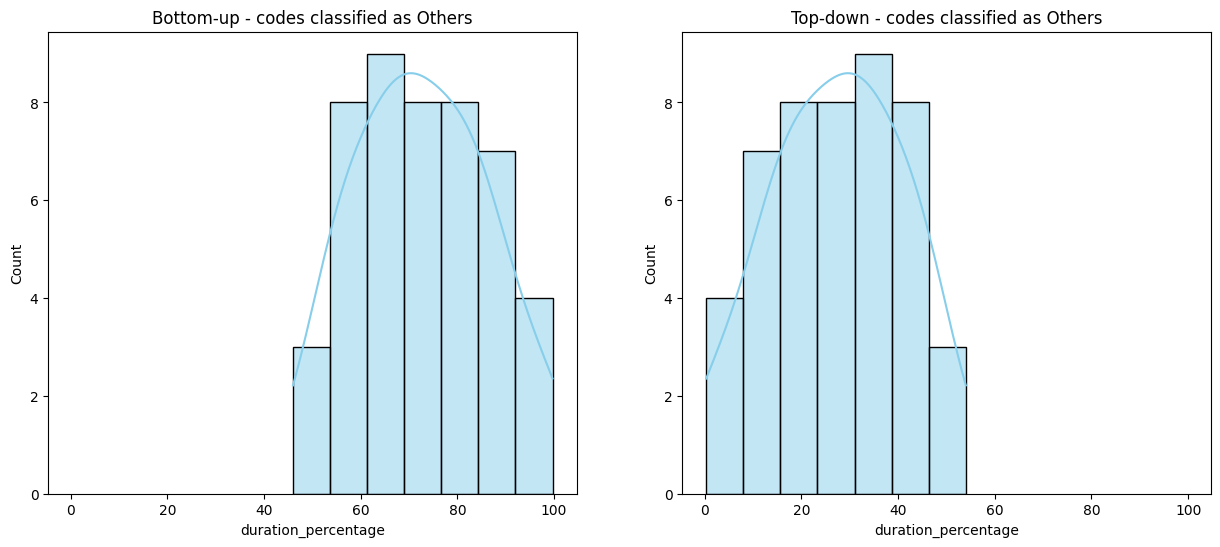

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.histplot(others_bottom_up['duration_percentage'], ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Bottom-up - codes classified as Others')

sns.histplot(others_top_down['duration_percentage'], ax=ax[1], kde=True, color='skyblue')
ax[1].set_title('Top-down - codes classified as Others')

plt.show()

#### Teste para verificar a normalidade (Shapiro-Wilk)

---



    H0: A distribuição é aproximadamente normal.
    H1: A distribuição não é aproximadamente normal

In [65]:
statistic_bottom_up, p_value_bottom_up = shapiro(others_bottom_up['duration_percentage'])
statistic_top_down, p_value_top_down = shapiro(others_top_down['duration_percentage'])

alpha = 0.05

if p_value_bottom_up > alpha:
    print("A distribuição de 'others_bottom_up' é aproximadamente normal.")
else:
    print("A distribuição de 'others_bottom_up' não é aproximadamente normal.")

if p_value_top_down > alpha:
    print("A distribuição de 'others_top_down' é aproximadamente normal.")
else:
    print("A distribuição de 'others_top_down' não é aproximadamente normal.")

A distribuição de 'others_bottom_up' é aproximadamente normal.
A distribuição de 'others_top_down' é aproximadamente normal.


#### Diferença para códigos que foram classificados como Others (bottom-up vs top-down):

---



    H0: Em códigos classificados como Others, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

    H1: Em códigos classificados como Others, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
    (bottom-up vs top-down).

In [66]:
statistic, p_value = wilcoxon(others_bottom_up['duration_percentage'], others_top_down['duration_percentage'])

print(f"Wilcoxon statistic: {statistic}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")
else:
    print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.")

Wilcoxon statistic: 5.0
p-value: 1.4210854715202004e-13
H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada modelo mental.


In [67]:
n_others_bottom_up = len(others_bottom_up)
n_others_top_down = len(others_top_down)

print(f"n_others_bottom_up: {n_others_bottom_up}")
print(f"n_others_top_down: {n_others_top_down}")

mu_u = (n_others_bottom_up * n_others_top_down) / 2

sigma_u = np.sqrt((n_others_bottom_up * n_others_top_down * (n_others_bottom_up + n_others_top_down + 1)) / 12)

combined_data = np.concatenate([others_bottom_up['duration_percentage'], others_top_down['duration_percentage']])

ranks = rankdata(combined_data)

ranks_others_bottom_up = ranks[:len(others_bottom_up['duration_percentage'])]
ranks_others_top_down = ranks[len(others_top_down['duration_percentage']):]

sum_ranks_others_bottom_up = np.sum(ranks_others_bottom_up)
sum_ranks_others_top_down = np.sum(ranks_others_top_down)

print(f"Soma dos ranks de 'others_bottom_up': {sum_ranks_others_bottom_up}")
print(f"Soma dos ranks de 'others_top_down': {sum_ranks_others_top_down}")

z = (statistic - mu_u) / sigma_u

print("Estatística Z:", z)

n_others_bottom_up: 47
n_others_top_down: 47
Soma dos ranks de 'others_bottom_up': 3329.0
Soma dos ranks de 'others_top_down': 1136.0
Estatística Z: -8.314309673567516


## Reading Patterns por tipo de smell nas respostas

In [68]:
result_df

,experiment_id,code_snippet,duration,What code smell(s)?,mental_model,code_smell_type,source_file_line,section,event,classified_as_smell
0,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside,True
1,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside,True
2,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside,True
3,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside,True
4,1.0,2.0,157,Long Method,top-down,Long Method,86,29,top-down-inside,True
...,...,...,...,...,...,...,...,...,...,...
90824,27.0,13.0,274,None,bottom-up,Data Class,959,320,bottom-up-outside,False
90825,27.0,13.0,460,None,bottom-up,Data Class,962,321,bottom-up-outside,False
90826,27.0,13.0,675,None,bottom-up,Data Class,959,320,bottom-up-outside,False
90827,27.0,13.0,367,None,bottom-up,Data Class,962,321,bottom-up-outside,False


In [69]:
long_method = fix_response[fix_response['What code smell(s)?'] == 'Long Method']
data_class = fix_response[fix_response['What code smell(s)?'] == 'Data Class']
data_feature_envy = fix_response[fix_response['What code smell(s)?'] == 'Feature Envy']
none = fix_response[fix_response['What code smell(s)?'] == 'None']
others = fix_response[fix_response['What code smell(s)?'] == 'Other']

In [70]:
long_method

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id,mental_model,classified_as_smell
0,2,77,1697813303583,107.0,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down,True
2,2,86,1697813303759,157.0,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Long Method,2.0,1.0,top-down,True
4,2,83,1697813303966,374.0,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,Long Method,28,Long Method,2.0,1.0,bottom-up,True
6,2,77,1697813304400,97.0,2023-10-20T11:48:24.400000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down,True
8,2,81,1697813304546,370.0,2023-10-20T11:48:24.546000000,top-down-inside,1,minor,Long Method,27,Long Method,2.0,1.0,top-down,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81622,11,454,1714690123528,593.0,2024-05-02T19:48:43.528000000,bottom-up-outside,27,critical,Long Method,152,Long Method,11.0,27.0,bottom-up,True
81623,11,452,1714690129432,116.0,2024-05-02T19:48:49.432000000,bottom-up-outside,27,critical,Long Method,151,Long Method,11.0,27.0,bottom-up,True
81624,11,453,1714690130612,200.0,2024-05-02T19:48:50.612000000,bottom-up-outside,27,critical,Long Method,151,Long Method,11.0,27.0,bottom-up,True
81625,11,449,1714690130888,350.0,2024-05-02T19:48:50.888000000,bottom-up-outside,27,critical,Long Method,150,Long Method,11.0,27.0,bottom-up,True


### Funções para realizar os testes

In [71]:
def gera_testes_ttb_btt(df, smell_type):
    fix_patterns = pd.DataFrame()

    # top-to-bottom vs bottom-to-top
    for snippet in df['code_snippet'].unique():
        for experiment in df['experiment_id'].unique():
            fixation_ = df.loc[(df['code_snippet'] == snippet) & (df['experiment_id'] == experiment)].copy()

            fixation_['pattern'] = fixation_['source_file_line'].diff().apply(lambda x: 'top-to-bottom' if x >=0 else 'bottom-to-top')

            fix_patterns = pd.concat([fix_patterns, fixation_])

    count = fix_patterns.groupby(['code_snippet', 'experiment_id', 'pattern'])['duration'].count()

    count_normalized = count / count.groupby(['code_snippet', 'experiment_id']).transform('sum') * 100

    count_normalized = count_normalized.reset_index(name='duration_percentage')

    bottom_to_top = count_normalized[count_normalized['pattern'] == 'bottom-to-top']
    top_to_bottom = count_normalized[count_normalized['pattern'] == 'top-to-bottom']

    if len(bottom_to_top) > len(top_to_bottom):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'top_to_bottom'
        count_normalized.loc[len(count_normalized)] = unique_value

    elif len(bottom_to_top) < len(top_to_bottom):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'bottom_to_top'

    bottom_to_top = count_normalized[count_normalized['pattern'] == 'bottom-to-top']
    top_to_bottom = count_normalized[count_normalized['pattern'] == 'top-to-bottom']

    #  calculando N

    print("Tamanho da amostra:")
    print(f"bottom_to_top: {len(bottom_to_top)}")
    print(f"top_to_bottom: {len(top_to_bottom)}\n")

    print("Soma dos ranks (T):")

    # soma dos ranks
    diffs = top_to_bottom['duration_percentage'].values - bottom_to_top['duration_percentage'].values
    ranks = rankdata(np.abs(diffs))

    T_top_to_bottom = np.sum(ranks[diffs > 0])
    T_bottom_to_top = np.sum(ranks[diffs < 0])

    print(f"Soma dos ranks para top_to_bottom: {T_top_to_bottom}")
    print(f"Soma dos ranks para bottom_to_top: {T_bottom_to_top}\n\n")

    statistic, p_value = wilcoxon(bottom_to_top['duration_percentage'], top_to_bottom['duration_percentage'])

    n = len(diffs[diffs != 0])

    # Estatística Z
    mean_T = n * (n + 1) / 4
    std_T = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Calculando a estatística Z
    Z = (statistic - mean_T) / std_T

    print(f"Estatística Z: {Z}\n\n")

    print(f"""Diferença de bottom-to-top vs top-to-bottom em {smell_type}:

H0: Em códigos classificados como {smell_type}, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como {smell_type}, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).\n""")

    print(f"Wilcoxon statistic: {statistic}")
    print(f"p-value: {p_value}\n")

    alpha = 0.05

    if p_value < alpha:
        print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.\n\n")
    else:
        print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.\n\n")


In [72]:
def gera_testes_disordely_sectionally(df, smell_type):
    fix_patterns = pd.DataFrame()

    for snippet in df['code_snippet'].unique():
        for experiment in df['experiment_id'].unique():
            fixation_ = df.loc[(df['code_snippet'] == snippet) & (df['experiment_id'] == experiment)].copy()

            fixation_['pattern'] = fixation_['section'].diff().apply(lambda x: 'disordely' if x != 0 else 'sectionally')

            fix_patterns = pd.concat([fix_patterns, fixation_])

    count = fix_patterns.groupby(['code_snippet', 'experiment_id', 'pattern'])['duration'].count()

    count_normalized = count / count.groupby(['code_snippet', 'experiment_id']).transform('sum') * 100

    count_normalized = count_normalized.reset_index(name='duration_percentage')

    disordely = count_normalized[count_normalized['pattern'] == 'disordely']
    sectionally = count_normalized[count_normalized['pattern'] == 'sectionally']

    if len(disordely) > len(sectionally):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'sectionally'
        count_normalized.loc[len(count_normalized)] = unique_value

    elif len(disordely) < len(sectionally):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'disordely'

        count_normalized.loc[len(count_normalized)] = unique_value

    disordely = count_normalized[count_normalized['pattern'] == 'disordely']
    sectionally = count_normalized[count_normalized['pattern'] == 'sectionally']

    #  calculando N
    print("Tamanho da amostra:")
    print(f"disordely: {len(disordely)}")
    print(f"sectionally: {len(sectionally)}\n")

    diffs = disordely['duration_percentage'].values - sectionally['duration_percentage'].values

    print("Soma dos ranks (T):")

    ranks = rankdata(np.abs(diffs))

    T_disordely = np.sum(ranks[diffs > 0])
    T_sectionally = np.sum(ranks[diffs < 0])

    print(f"Soma dos ranks para disordely: {T_disordely}")
    print(f"Soma dos ranks para sectionally: {T_sectionally}\n\n")

    # realizacao do teste
    statistic, p_value = wilcoxon(disordely['duration_percentage'], sectionally['duration_percentage'])

    n = len(diffs[diffs != 0])

    # Estatística Z
    mean_T = n * (n + 1) / 4
    std_T = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Calculando a estatística Z
    Z = (statistic - mean_T) / std_T

    print(f"Estatística Z: {Z}\n\n")

    print(f"""Diferença de disordely vs sectionally em {smell_type}:

H0: Em códigos classificados como {smell_type} não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como {smell_type}, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).\n""")

    print(f"Wilcoxon statistic: {statistic}")
    print(f"p-value: {p_value}\n")

    alpha = 0.05

    if p_value < alpha:
        print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.\n\n")
    else:
        print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em padrão de leitura.\n\n")

In [73]:
def gera_testes_skimming_thorough(df, smell_type):
    fix_patterns = pd.DataFrame()

    for snippet in df['code_snippet'].unique():
        for experiment in df['experiment_id'].unique():
            fixation_ = df.loc[(df['code_snippet'] == snippet) & (df['experiment_id'] == experiment)].copy()

            fixation_['pattern'] = fixation_['duration'].apply(lambda x: 'thorough' if x > 1000 else 'skimming')

            fix_patterns = pd.concat([fix_patterns, fixation_])

    count = fix_patterns.groupby(['code_snippet', 'experiment_id', 'pattern'])['duration'].count()

    count_normalized = count / count.groupby(['code_snippet', 'experiment_id']).transform('sum') * 100

    count_normalized = count_normalized.reset_index(name='duration_percentage')

    thorough = count_normalized[count_normalized['pattern'] == 'thorough']
    skimming = count_normalized[count_normalized['pattern'] == 'skimming']

    if len(thorough) > len(skimming):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'skimming'
        count_normalized.loc[len(count_normalized)] = unique_value

    elif len(thorough) < len(skimming):
        unique_value = count_normalized.loc[count_normalized['duration_percentage'] == 100].values[0]
        unique_value[2] = 'thorough'

        count_normalized.loc[len(count_normalized)] = unique_value

    thorough = count_normalized[count_normalized['pattern'] == 'thorough']
    skimming = count_normalized[count_normalized['pattern'] == 'skimming']

    #  calculando N
    print("Tamanho da amostra:")
    print(f"thorough: {len(thorough)}")
    print(f"skimming: {len(skimming)}\n")

    diffs = thorough['duration_percentage'].values - skimming['duration_percentage'].values

    print("Soma dos ranks (T):")

    ranks = rankdata(np.abs(diffs))

    T_thorough = np.sum(ranks[diffs > 0])
    T_skimming = np.sum(ranks[diffs < 0])

    print(f"Soma dos ranks para thorough: {T_thorough}")
    print(f"Soma dos ranks para skimming: {T_skimming}\n\n")

    statistic, p_value = wilcoxon(thorough['duration_percentage'], skimming['duration_percentage'])

    n = len(diffs[diffs != 0])

    # Estatística Z
    mean_T = n * (n + 1) / 4
    std_T = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Calculando a estatística Z
    Z = (statistic - mean_T) / std_T

    print(f"Estatística Z: {Z}\n\n")

    print(f"""Diferença de skimming vs thorough em {smell_type}:

H0: Em códigos classificados como {smell_type}, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como {smell_type}, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).\n""")

    print(f"Wilcoxon statistic: {statistic}")
    print(f"p-value: {p_value}\n")

    alpha = 0.05

    if p_value < alpha:
        print("H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.\n\n")
    else:
        print("H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.\n\n")

### Long Method

In [74]:
gera_testes_ttb_btt(long_method, 'Long Method')

Tamanho da amostra:
bottom_to_top: 49
top_to_bottom: 49

Soma dos ranks (T):
Soma dos ranks para top_to_bottom: 1224.0
Soma dos ranks para bottom_to_top: 0.0


Estatística Z: -6.030848532388999


Diferença de bottom-to-top vs top-to-bottom em Long Method:

H0: Em códigos classificados como Long Method, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como Long Method, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).

Wilcoxon statistic: 0.0
p-value: 1.6306098573244595e-09

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [75]:
gera_testes_disordely_sectionally(long_method, 'Long Method')

Tamanho da amostra:
disordely: 49
sectionally: 49

Soma dos ranks (T):
Soma dos ranks para disordely: 486.0
Soma dos ranks para sectionally: 739.0


Estatística Z: -1.2583327701940443


Diferença de disordely vs sectionally em Long Method:

H0: Em códigos classificados como Long Method não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como Long Method, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).

Wilcoxon statistic: 486.0
p-value: 0.21210233030761216

H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em padrão de leitura.




In [76]:
gera_testes_skimming_thorough(long_method, 'Long Method')

Tamanho da amostra:
thorough: 49
skimming: 49

Soma dos ranks (T):
Soma dos ranks para thorough: 0.0
Soma dos ranks para skimming: 1225.0


Estatística Z: -6.092717958449424


Diferença de skimming vs thorough em Long Method:

H0: Em códigos classificados como Long Method, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como Long Method, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).

Wilcoxon statistic: 0.0
p-value: 3.552713678800501e-15

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




### Data Class

In [77]:
gera_testes_ttb_btt(data_class, 'Data Class')

Tamanho da amostra:
bottom_to_top: 37
top_to_bottom: 37

Soma dos ranks (T):
Soma dos ranks para top_to_bottom: 703.0
Soma dos ranks para bottom_to_top: 0.0


Estatística Z: -5.302829433425141


Diferença de bottom-to-top vs top-to-bottom em Data Class:

H0: Em códigos classificados como Data Class, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como Data Class, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).

Wilcoxon statistic: 0.0
p-value: 1.4551915228366852e-11

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [78]:
gera_testes_disordely_sectionally(data_class, 'Data Class')

Tamanho da amostra:
disordely: 37
sectionally: 37

Soma dos ranks (T):
Soma dos ranks para disordely: 549.0
Soma dos ranks para sectionally: 153.0


Estatística Z: -2.9692986617654245


Diferença de disordely vs sectionally em Data Class:

H0: Em códigos classificados como Data Class não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como Data Class, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).

Wilcoxon statistic: 144.0
p-value: 0.002984803394721606

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [79]:
gera_testes_skimming_thorough(data_class, 'Data Class')

Tamanho da amostra:
thorough: 37
skimming: 37

Soma dos ranks (T):
Soma dos ranks para thorough: 0.0
Soma dos ranks para skimming: 703.0


Estatística Z: -5.302829433425141


Diferença de skimming vs thorough em Data Class:

H0: Em códigos classificados como Data Class, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como Data Class, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).

Wilcoxon statistic: 0.0
p-value: 1.4551915228366852e-11

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




### Feature Envy

In [80]:
gera_testes_ttb_btt(data_feature_envy, 'Feature Envy')

Tamanho da amostra:
bottom_to_top: 33
top_to_bottom: 33

Soma dos ranks (T):
Soma dos ranks para top_to_bottom: 561.0
Soma dos ranks para bottom_to_top: 0.0


Estatística Z: -5.011926075380066


Diferença de bottom-to-top vs top-to-bottom em Feature Envy:

H0: Em códigos classificados como Feature Envy, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como Feature Envy, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).

Wilcoxon statistic: 0.0
p-value: 2.3283064365386963e-10

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [81]:
gera_testes_disordely_sectionally(data_feature_envy, 'Feature Envy')

Tamanho da amostra:
disordely: 33
sectionally: 33

Soma dos ranks (T):
Soma dos ranks para disordely: 301.0
Soma dos ranks para sectionally: 260.0


Estatística Z: -0.3662904974876697


Diferença de disordely vs sectionally em Feature Envy:

H0: Em códigos classificados como Feature Envy não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como Feature Envy, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).

Wilcoxon statistic: 260.0
p-value: 0.7242955029942095

H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em padrão de leitura.




In [82]:
gera_testes_skimming_thorough(data_feature_envy, 'Feature Envy')

Tamanho da amostra:
thorough: 33
skimming: 33

Soma dos ranks (T):
Soma dos ranks para thorough: 1.0
Soma dos ranks para skimming: 560.0


Estatística Z: -4.994058246234325


Diferença de skimming vs thorough em Feature Envy:

H0: Em códigos classificados como Feature Envy, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como Feature Envy, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).

Wilcoxon statistic: 1.0
p-value: 4.656612873077393e-10

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




### None

In [83]:
gera_testes_ttb_btt(none, 'None')

Tamanho da amostra:
bottom_to_top: 148
top_to_bottom: 148

Soma dos ranks (T):
Soma dos ranks para top_to_bottom: 11025.0
Soma dos ranks para bottom_to_top: 0.0


Estatística Z: -10.517781553804934


Diferença de bottom-to-top vs top-to-bottom em None:

H0: Em códigos classificados como None, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como None, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).

Wilcoxon statistic: 0.0
p-value: 7.152133208173667e-26

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [84]:
gera_testes_disordely_sectionally(none, 'None')

Tamanho da amostra:
disordely: 148
sectionally: 148

Soma dos ranks (T):
Soma dos ranks para disordely: 6283.0
Soma dos ranks para sectionally: 4743.0


Estatística Z: -1.47398861633963


Diferença de disordely vs sectionally em None:

H0: Em códigos classificados como None não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como None, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).

Wilcoxon statistic: 4743.0
p-value: 0.1404846561984544

H0 não rejeitada. Não há diferença significativa entre a porcentagem do tempo gasto em padrão de leitura.




In [85]:
gera_testes_skimming_thorough(none, 'None')

Tamanho da amostra:
thorough: 148
skimming: 148

Soma dos ranks (T):
Soma dos ranks para thorough: 0.0
Soma dos ranks para skimming: 11026.0


Estatística Z: -10.553375638805688


Diferença de skimming vs thorough em None:

H0: Em códigos classificados como None, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como None, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).

Wilcoxon statistic: 0.0
p-value: 4.89966374184659e-26

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




### Others

In [86]:
gera_testes_ttb_btt(others, 'Others')

Tamanho da amostra:
bottom_to_top: 47
top_to_bottom: 47

Soma dos ranks (T):
Soma dos ranks para top_to_bottom: 1128.0
Soma dos ranks para bottom_to_top: 0.0


Estatística Z: -5.968337509858079


Diferença de bottom-to-top vs top-to-bottom em Others:

H0: Em códigos classificados como Others, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).
H1: Em códigos classificados como Others, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(top-to-bottom vs bottom-to-top).

Wilcoxon statistic: 0.0
p-value: 1.4210854715202004e-14

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [87]:
gera_testes_disordely_sectionally(others, 'Others')

Tamanho da amostra:
disordely: 47
sectionally: 47

Soma dos ranks (T):
Soma dos ranks para disordely: 367.0
Soma dos ranks para sectionally: 761.0


Estatística Z: -2.084685264968159


Diferença de disordely vs sectionally em Others:

H0: Em códigos classificados como Others não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).
H1: Em códigos classificados como Others, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(disordely vs sectionally).

Wilcoxon statistic: 367.0
p-value: 0.036746795672257804

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




In [88]:
gera_testes_skimming_thorough(others, 'Others')

Tamanho da amostra:
thorough: 47
skimming: 47

Soma dos ranks (T):
Soma dos ranks para thorough: 0.0
Soma dos ranks para skimming: 1128.0


Estatística Z: -5.968337509858079


Diferença de skimming vs thorough em Others:

H0: Em códigos classificados como Others, não há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).
H1: Em códigos classificados como Others, há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura
(thorough vs skimming).

Wilcoxon statistic: 0.0
p-value: 1.4210854715202004e-14

H0 rejeitada. Há diferença significativa entre a porcentagem do tempo gasto em cada padrão de leitura.




## Criação da tabela do tempo médio de leitura bottom-up ou top-down por tipo de smells na resposta

In [89]:
fix_response['location'] = fix_response['event'].apply(lambda x: 'inside' if 'inside' in x else 'outside')

In [90]:
result_df_duration_smell = fix_response.groupby(['What code smell(s)?', 'experiment_id', 'code_snippet', 'mental_model', 'location'])['duration'].sum()
result_df_duration_smell.head()

What code smell(s)?  experiment_id  code_snippet  mental_model  location
Data Class           1.0            9.0           bottom-up     inside      19206.000
                                                  top-down      inside      11684.695
                     3.0            3.0           bottom-up     inside      64063.255
                                                  top-down      inside      20317.000
                                                                outside       200.000
Name: duration, dtype: float64

In [91]:
mean_data_class_bottom_up_inside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "bottom-up", 'inside')].mean()
mean_data_class_bottom_up_outside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "bottom-up", 'outside')].mean()
mean_data_class_top_down_inside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "top-down", 'inside')].mean()
mean_data_class_top_down_outside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "top-down", 'outside')].mean()

mean_feature_envy_bottom_up_inside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "bottom-up", 'inside')].mean()
mean_feature_envy_bottom_up_outside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "bottom-up", 'outside')].mean()
mean_feature_envy_top_down_inside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "top-down", 'inside')].mean()
mean_feature_envy_top_down_outside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "top-down", 'outside')].mean()

mean_long_method_bottom_up_inside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "bottom-up", 'inside')].mean()
mean_long_method_bottom_up_outside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "bottom-up", 'outside')].mean()
mean_long_method_top_down_inside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "top-down", 'inside')].mean()
mean_long_method_top_down_outside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "top-down", 'outside')].mean()

mean_none_bottom_up_inside = result_df_duration_smell.loc[('None', slice(None), slice(None), "bottom-up", 'inside')].mean()
mean_none_bottom_up_outside = result_df_duration_smell.loc[('None', slice(None), slice(None), "bottom-up", 'outside')].mean()
mean_none_top_down_inside = result_df_duration_smell.loc[('None', slice(None), slice(None), "top-down", 'inside')].mean()
mean_none_top_down_outside = result_df_duration_smell.loc[('None', slice(None), slice(None), "top-down", 'outside')].mean()

mean_others_bottom_up_inside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "bottom-up", 'inside')].mean()
mean_others_bottom_up_outside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "bottom-up", 'outside')].mean()
mean_others_top_down_inside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "top-down", 'inside')].mean()
mean_others_top_down_outside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "top-down", 'outside')].mean()

print(f'Data Class bottom-up inside: {mean_data_class_bottom_up_inside}')
print(f'Data Class bottom-up outside: {mean_data_class_bottom_up_outside}')
print(f'Data Class top-down inside: {mean_data_class_top_down_inside}')
print(f'Data Class top-down outside: {mean_data_class_top_down_outside}')
print(f'Feature Envy bottom-up inside: {mean_feature_envy_bottom_up_inside}')
print(f'Feature Envy bottom-up outside: {mean_feature_envy_bottom_up_outside}')
print(f'Feature Envy top-down inside: {mean_feature_envy_top_down_inside}')
print(f'Feature Envy top-down outside: {mean_feature_envy_top_down_outside}')
print(f'Long Method bottom-up inside: {mean_long_method_bottom_up_inside}')
print(f'Long Method bottom-up outside: {mean_long_method_bottom_up_outside}')
print(f'Long Method top-down inside: {mean_long_method_top_down_inside}')
print(f'Long Method top-down outside: {mean_long_method_top_down_outside}')
print(f'None bottom-up inside: {mean_none_bottom_up_inside}')
print(f'None bottom-up outside: {mean_none_bottom_up_outside}')
print(f'None top-down inside: {mean_none_top_down_inside}')
print(f'None top-down outside: {mean_none_top_down_outside}')
print(f'Others bottom-up inside: {mean_others_bottom_up_inside}')
print(f'Others bottom-up outside: {mean_others_bottom_up_outside}')
print(f'Others top-down inside: {mean_others_top_down_inside}')
print(f'Others top-down outside: {mean_others_top_down_outside}')

Data Class bottom-up inside: 62098.25035714286
Data Class bottom-up outside: 26786.405000000002
Data Class top-down inside: 32556.727142857137
Data Class top-down outside: 6503.253285714286
Feature Envy bottom-up inside: 76980.75246875
Feature Envy bottom-up outside: 18697.02028
Feature Envy top-down inside: 42166.03646875
Feature Envy top-down outside: 7583.121433333335
Long Method bottom-up inside: 89019.81197777778
Long Method bottom-up outside: 26453.929139534885
Long Method top-down inside: 38655.4298
Long Method top-down outside: 3902.370638297872
None bottom-up inside: 55288.74107086615
None bottom-up outside: 31018.665593495934
None top-down inside: 28787.8496875
None top-down outside: 6517.346656934306
Others bottom-up inside: 90456.10833333332
Others bottom-up outside: 39902.41363636364
Others top-down inside: 35315.34642857143
Others top-down outside: 5571.874999999999


In [92]:
percentage_data_class_bottom_up_inside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "bottom-up", 'inside')].sum() / result_df_duration_smell.loc[('Data Class')].sum()
percentage_data_class_bottom_up_outside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "bottom-up", 'outside')].sum() / result_df_duration_smell.loc[('Data Class')].sum()
percentage_data_class_top_down_inside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "top-down", 'inside')].sum() / result_df_duration_smell.loc[('Data Class')].sum()
percentage_data_class_top_down_outside = result_df_duration_smell.loc[('Data Class', slice(None), slice(None), "top-down", 'outside')].sum() / result_df_duration_smell.loc[('Data Class')].sum()

percentade_feature_envy_bottom_up_inside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "bottom-up", 'inside')].sum() / result_df_duration_smell.loc[('Feature Envy')].sum()
percentade_feature_envy_bottom_up_outside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "bottom-up", 'outside')].sum() / result_df_duration_smell.loc[('Feature Envy')].sum()
percentage_feature_envy_top_down_inside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "top-down", 'inside')].sum() / result_df_duration_smell.loc[('Feature Envy')].sum()
percentage_feature_envy_top_down_outside = result_df_duration_smell.loc[('Feature Envy', slice(None), slice(None), "top-down", 'outside')].sum() / result_df_duration_smell.loc[('Feature Envy')].sum()

percentage_long_method_bottom_up_inside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "bottom-up", 'inside')].sum() / result_df_duration_smell.loc[('Long Method')].sum()
percentage_long_method_bottom_up_outside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "bottom-up", 'outside')].sum() / result_df_duration_smell.loc[('Long Method')].sum()
percentage_long_method_top_down_inside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "top-down", 'inside')].sum() / result_df_duration_smell.loc[('Long Method')].sum()
percentage_long_method_top_down_outside = result_df_duration_smell.loc[('Long Method', slice(None), slice(None), "top-down", 'outside')].sum() / result_df_duration_smell.loc[('Long Method')].sum()

percentage_none_bottom_up_inside = result_df_duration_smell.loc[('None', slice(None), slice(None), "bottom-up", 'inside')].sum() / result_df_duration_smell.loc[('None')].sum()
percentage_none_bottom_up_outside = result_df_duration_smell.loc[('None', slice(None), slice(None), "bottom-up", 'outside')].sum() / result_df_duration_smell.loc[('None')].sum()
percentage_none_top_down_inside = result_df_duration_smell.loc[('None', slice(None), slice(None), "top-down", 'inside')].sum() / result_df_duration_smell.loc[('None')].sum()
percentage_none_top_down_outside = result_df_duration_smell.loc[('None', slice(None), slice(None), "top-down", 'outside')].sum() / result_df_duration_smell.loc[('None')].sum()

percentage_others_bottom_up_inside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "bottom-up", 'inside')].sum() / result_df_duration_smell.loc[('Other')].sum()
percentage_others_bottom_up_outside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "bottom-up", 'outside')].sum() / result_df_duration_smell.loc[('Other')].sum()
percentage_others_top_down_inside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "top-down", 'inside')].sum() / result_df_duration_smell.loc[('Other')].sum()
percentage_others_top_down_outside = result_df_duration_smell.loc[('Other', slice(None), slice(None), "top-down", 'outside')].sum() / result_df_duration_smell.loc[('Other')].sum()

print("Percentage of duration in each smell type:")
print("Duration percentage data class bottom up inside:", percentage_data_class_bottom_up_inside)
print("Duration percentage data class bottom up outside:", percentage_data_class_bottom_up_outside)
print("Duration percentage data class top down inside:", percentage_data_class_top_down_inside)
print("Duration percentage data class top down outside:", percentage_data_class_top_down_outside)

sum_data_class = percentage_data_class_bottom_up_inside + percentage_data_class_bottom_up_outside + percentage_data_class_top_down_inside + percentage_data_class_top_down_outside

print("Sum data class:", sum_data_class)

print("Duration percentage feature envy bottom up inside:", percentade_feature_envy_bottom_up_inside)
print("Duration percentage feature envy bottom up outside:", percentade_feature_envy_bottom_up_outside)
print("Duration percentage feature envy top down inside:", percentage_feature_envy_top_down_inside)
print("Duration percentage feature envy top down outside:", percentage_feature_envy_top_down_outside)

sum_feature_envy = percentade_feature_envy_bottom_up_inside + percentade_feature_envy_bottom_up_outside + percentage_feature_envy_top_down_inside + percentage_feature_envy_top_down_outside

print("Sum feature envy:", sum_feature_envy)

print("Duration percentage long method bottom up inside:", percentage_long_method_bottom_up_inside)
print("Duration percentage long method bottom up outside:", percentage_long_method_bottom_up_outside)
print("Duration percentage long method top down inside:", percentage_long_method_top_down_inside)
print("Duration percentage long method top down outside:", percentage_long_method_top_down_outside)

sum_long_method = percentage_long_method_bottom_up_inside + percentage_long_method_bottom_up_outside + percentage_long_method_top_down_inside + percentage_long_method_top_down_outside


print("Sum long method:", sum_long_method)

print("Duration percentage none bottom up inside:", percentage_none_bottom_up_inside)
print("Duration percentage none bottom up outside:", percentage_none_bottom_up_outside)
print("Duration percentage none top down inside:", percentage_none_top_down_inside)
print("Duration percentage none top down outside:", percentage_none_top_down_outside)

sum_none = percentage_none_bottom_up_inside + percentage_none_bottom_up_outside + percentage_none_top_down_inside + percentage_none_top_down_outside

print("Sum none:", sum_none)

print("Duration percentage others bottom up inside:", percentage_others_bottom_up_inside)
print("Duration percentage others bottom up outside:", percentage_others_bottom_up_outside)
print("Duration percentage others top down inside:", percentage_others_top_down_inside)
print("Duration percentage others top down outside:", percentage_others_top_down_outside)

sum_others = percentage_others_bottom_up_inside + percentage_others_bottom_up_outside + percentage_others_top_down_inside + percentage_others_top_down_outside

print("Sum others:", sum_others)

Percentage of duration in each smell type:
Duration percentage data class bottom up inside: 0.4828273040935288
Duration percentage data class bottom up outside: 0.200831865074057
Duration percentage data class top down inside: 0.25313558282381166
Duration percentage data class top down outside: 0.0632052480086027
Sum data class: 1.0000000000000002
Duration percentage feature envy bottom up inside: 0.5464937258605179
Duration percentage feature envy bottom up outside: 0.10369682464878494
Duration percentage feature envy top down inside: 0.2993407265528102
Duration percentage feature envy top down outside: 0.05046872293788684
Sum feature envy: 0.9999999999999999
Duration percentage long method bottom up inside: 0.5668995549554269
Duration percentage long method bottom up outside: 0.16097764553306923
Duration percentage long method top down inside: 0.24616706622230483
Duration percentage long method top down outside: 0.02595573328919899
Sum long method: 0.9999999999999999
Duration percent